In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import skimage
import cv2
from scipy.ndimage.filters import convolve

Reading the image

(640, 640)


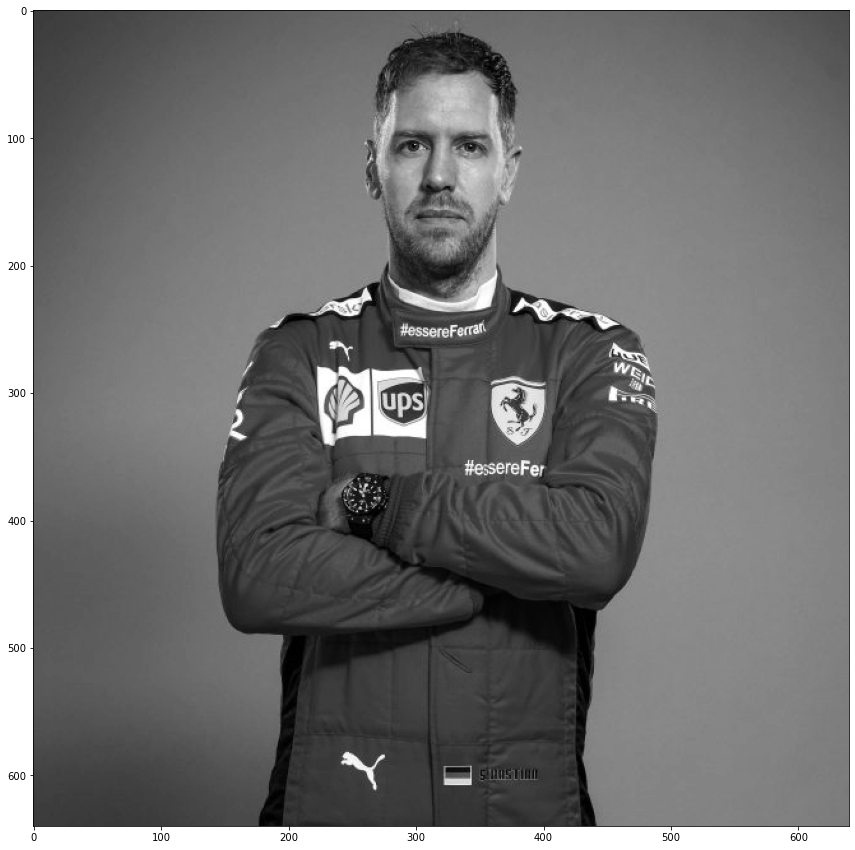

In [2]:
img = cv2.imread('images//seb.jpg',2)
print(img.shape)
plt.figure(figsize=(15,15))
plt.imshow(img,cmap="gray")
plt.show()

Canny Edge detection steps:
- Noise reduction;
- Gradient calculation;
- Non-maximum suppression;
- Double threshold;
- Edge Tracking by Hysteresis.

Step 1: Noise reduction - I am using linear gaussian kernels, which can reduce the number of multiplications.

In [15]:
def linearGaussianKernel(size,sigma=1.0):
    boundary_vals = int(size)//2
    x = np.arange(-boundary_vals,boundary_vals+1)
    normal = 1.0/(2.0*np.pi*sigma**2)
    kernel = np.exp(-((x**2) / (2.0*sigma**2))) * normal
    kernel = np.expand_dims(kernel,axis=0)
    return kernel

In [13]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

print(gaussian_kernel(5,1))

[[0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.02153928 0.09653235 0.15915494 0.09653235 0.02153928]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]]


In [63]:
print(np.transpose(linearGaussianKernel(kernel_size,sigma))*linearGaussianKernel(kernel_size,sigma))

[[0.00046394 0.00207924 0.00342808 0.00207924 0.00046394]
 [0.00207924 0.0093185  0.0153636  0.0093185  0.00207924]
 [0.00342808 0.0153636  0.0253303  0.0153636  0.00342808]
 [0.00207924 0.0093185  0.0153636  0.0093185  0.00207924]
 [0.00046394 0.00207924 0.00342808 0.00207924 0.00046394]]


In [64]:
kernel_size = 5
sigma = 1.0
img = img.astype(np.int32)
img_smoothed_vertical = convolve(img,np.transpose(linearGaussianKernel(kernel_size,sigma)))
img_smoothed = convolve(img_smoothed_vertical,linearGaussianKernel(kernel_size,sigma)*10)
img_smoothed = img_smoothed/img_smoothed.max() * 255.0

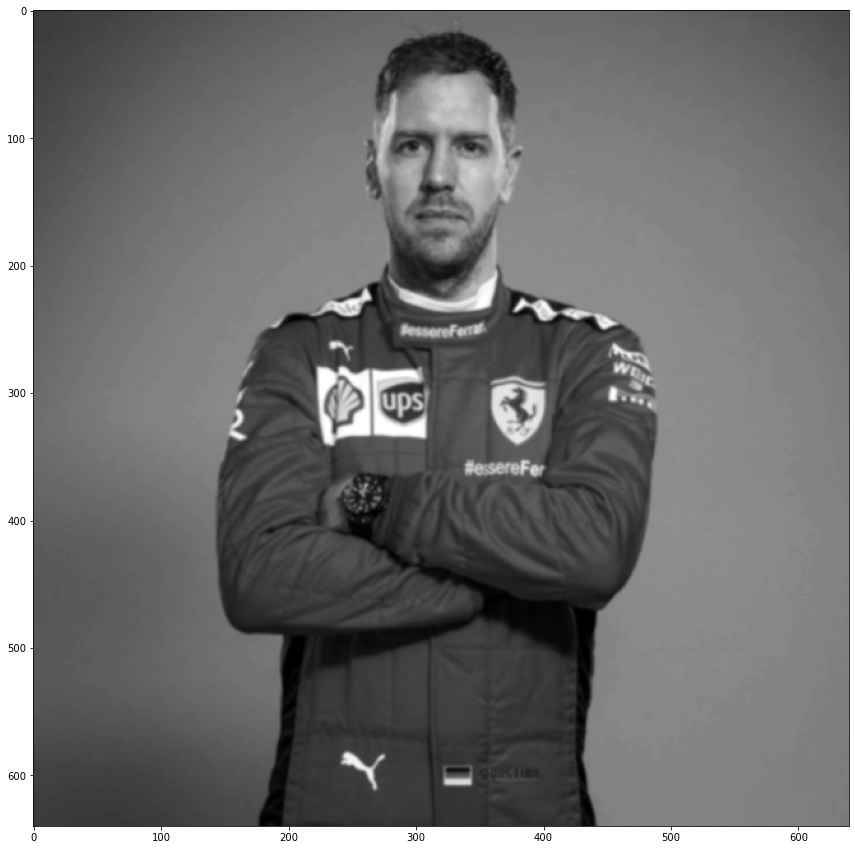

In [65]:
plt.figure(figsize=(15,15))
plt.imshow(img_smoothed,cmap="gray")
plt.show()

Step 2. Gradient calculation

In [66]:
def apply_sobel_filters(img):
    kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    ix = convolve(img,kx)
    iy = convolve(img,ky)
    G = np.sqrt(ix**2+iy**2)
    G = G/G.max() * 255.0
    
    angle = np.arctan2(iy,ix)
    
    return G,angle

In [67]:
img_gradient = apply_sobel_filters(img_smoothed)[0]

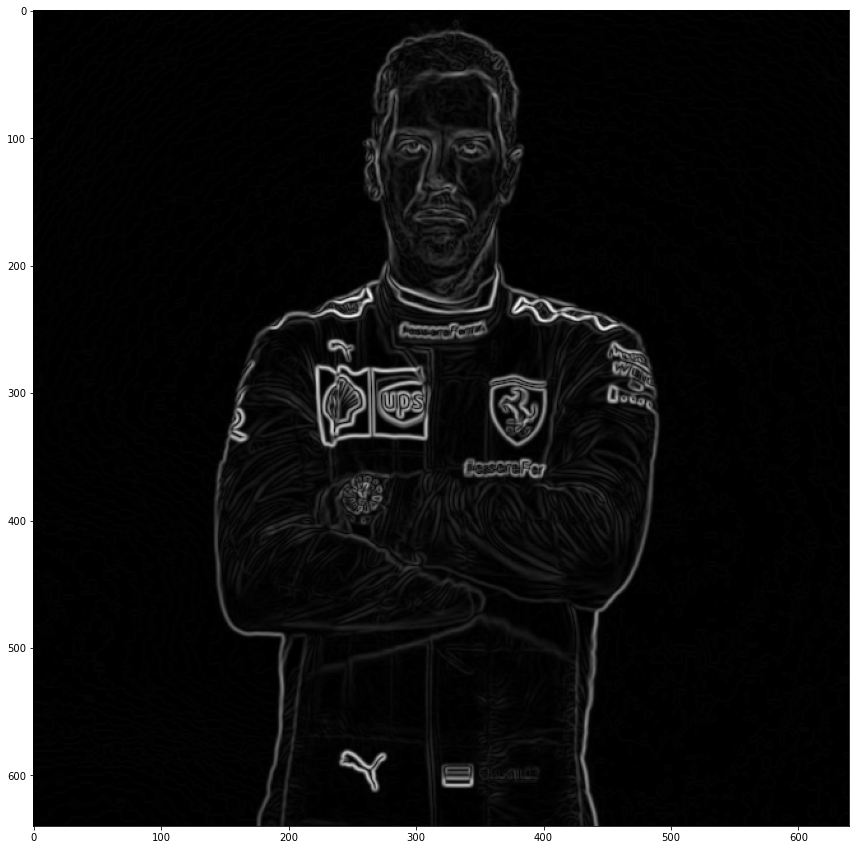

In [68]:
plt.figure(figsize=(15,15))
plt.imshow(img_gradient,cmap="gray")
plt.show()

In [ ]:
def nonMaximumSupression(img,angle):
    img_shape = img.shape
    output_img = np.zeros(img_shape,np.int32)
    if angle > -np.pi/8.0 and angle < np.pi/8.0:
    for i in range(1,img_shape[0]-1):
        for j in range(1,img_shape[1]-1):
            q = 255
            r = 255

           #angle 0
            if angle < np.pi/8.0 or angle > 7*np.pi/8.0:
                q = img[i, j+1]
                r = img[i, j-1]
            #angle 45
            elif (angle > np.pi/8.0 and angle < 3*np.pi/8.0):
                q = img[i+1, j-1]
                r = img[i-1, j+1]
            #angle 90
            elif (angle > 3*np.pi/8.0 and angle < 5*np.pi/8.0):
                q = img[i+1, j]
                r = img[i-1, j]
            #angle 135
            elif (angle > 5*np.pi/8.0 and angle < 7*np.pi/8.0):
                q = img[i-1, j-1]
                r = img[i+1, j+1]

            if (img[i,j] >= q) and (img[i,j] >= r):
                Z[i,j] = img[i,j]
            else:
                Z[i,j] = 0
    